#PAUL: Python Active-subspaces Utility Library

##Tutorial 2: Bounded inputs and a given interface

This iPython notebook shows many of the features of the Python Active-subspaces Utility Library (PAUL) for working with functions of several variables. We examine a quadratic function of 3 variables, and we approximate it by a function of 1 variable and 2 variables. We assume we are given interfaces to evaluate the function and its gradient given values for the inputs. 

The variables are each assumed bounded between -1 and 1, and the space of variables is equipped with a uniform weight function. 

First import the library.

In [1]:
%matplotlib inline
import numpy as np
import active_subspaces as asub
import matplotlib.pyplot as plt

We define the interfaces to the test function and its gradient. The function is a quadratic function of three variables. Its gradient is a vector with three components. The elements of the matrix _A_ are specially chosen so that the eigenvalues used to determine the dimension of the active subspace decay rapidly. 

In [2]:
# A quadratic function of 3 variables. 
def quad_fun(x):
    A = np.array([[ 0.2406659045776698, -0.3159904335007421, -0.1746908591702878],
                [-0.3159904335007421,  0.5532215729009683,  0.3777995408101305],
                [-0.1746908591702878,  0.3777995408101305,  0.3161125225213613]])
    x = x.reshape((3,1))
    return 0.5*np.dot(x.T,np.dot(A,x))

# The gradient of the quadratic function. 
def quad_dfun(x):
    A = np.array([[ 0.2406659045776698, -0.3159904335007421, -0.1746908591702878],
                [-0.3159904335007421,  0.5532215729009683,  0.3777995408101305],
                [-0.1746908591702878,  0.3777995408101305,  0.3161125225213613]])
    return np.dot(A,x.reshape((3,1)))

### QUICK START: Using the wrapper interfaces

What follows is the simplest way to construct and evaluate a model that uses active subspaces to reduce the dimension. The class `ActiveSubspaceReducedModel` contains many convenient functions for evaluating the model's prediction, estimating its average (i.e., integrating against the uniform weight function), and estimating the model's minimum. 

The function `build_from_interface` takes the interface, an optional argument `dfun` for the gradient interface, an optional argument `avdim` for the dimension of the active subspace, and a Boolean variable that tells the model that the inputs are bounded.

If `dfun` is not specified, the code estimates the gradients with finite differences. If `avdim` is not specified, the code uses a simple heuristic based on the eigenvalue gaps to choose a dimension for the active subspace.

After estimating the active subspace, `build_from_interface` constructs a radial basis response surface on a design-of-experiments. If the active subspace has dimension 1, then the design is uniformly space points on the range of the 1d active variable. Otherwise, it's a maximin design on the range of the active variable. That range is known as a _zonotope_, which is the projection of a hypercube. The response surface is called by the class's `predict` function, which returns the prediction and the gradient of the prediction. 

The class's `average` function estimates the average using a specially designed quadrature rule on the active variables and simple Monte Carlo on the inactive variables. The argument to the function is the total number of points in the active variable quadrature rule. The default number of Monte Carlo evaluations is 10. The reported bounds come from the Monte Carlo variance estimates. They are not likely to be conservative. In other words, the reported bounds are likely tighter than the actual error. 

The class's `minimum` function wraps the `scipy.optimize` sequential least-squares quadratic program (SLSQP) method applied to the response surfaces on the active variables. It then uses a heuristic for finding the minimum over the inactive variables. 

In [3]:
# Instantiate a wrapper class for the active subspace utilities.
m = 3
bounded_inputs = True
model = asub.ActiveSubspaceReducedModel(m, bounded_inputs)

# Build the active subspace-enabled model using the interfaces.
model.build_from_interface(quad_fun, dfun=quad_dfun, avdim=1)

# Compute the model's prediction and gradient at a random input point.
x = np.random.uniform(-1.0, 1.0, size=(1,m))
fx, dfx = model.predict(x, compgrad=True)
print 'At the point x = ({:4.2f}, {:4.2f}, {:4.2f})...'.format(
    x[0,0], x[0,1], x[0,2])
print '\tthe estimate is {:4.2f},'.format(fx[0,0])
print '\tand the estimated gradient is ({:4.2f}, {:4.2f}, {:4.2f}).\n'.format(
    dfx[0,0], dfx[0,1], dfx[0,2])

# Estimate the average of the model.
avavg = model.average(20)
print 'The estimated average is {:4.2f} with bounds [{:4.2f}, {:4.2f}].'.format(
    avavg[0], avavg[1], avavg[2])

# Estimate the minimum of the model and its minimizer.
avmin = model.minimum()
print 'The estimated minimum is {:4.2f} at x=({:4.2f}, {:4.2f}, {:4.2f}).'.format(
    avmin[0], avmin[1][0,0], avmin[1][0,1], avmin[1][0,2])

The dimension of the active subspace is 1.
At the point x = (-0.53, 0.98, 0.69)...
	the estimate is 0.87,
	and the estimated gradient is (-0.52, 0.96, 0.70).

The estimated average is 0.19 with bounds [0.18, 0.19].
The estimated minimum is 0.02 at x=(0.00, -0.00, -0.00).


### Digging deeper into the library

Let's dig deeper into the capabilities of the library. The functions exposed to the user allow greater control of the approximations. First, we use a `SimulationGradientRunner` to evaluate the gradient at 20 randomly sampled points in the input space.

In [4]:
# Get 20 samples of dimension 3 from the input space.
M0, m = 20, 3
X0 = np.random.uniform(-1.0, 1.0, size=(M0, m))

# Compute the gradient for each sample. 
dfX0 = asub.utils.simrunners.SimulationGradientRunner(quad_dfun).run(X0)

###Estimating the subspaces and the dimension of the active subspace
Next, we instantiate a `Subspaces` object and feed the gradient samples to the object's `compute` function, which estimates the active and inactive subspaces. This estimation uses a nonparametric bootstrap to estimate variability in the eigenvalue and subspace estimates. The plotting utilities `eigenvalues` and `subspace_errors` show, respectively, the estimated eigenvalues with boostrap ranges and the estimated error in the active subspace with bootstrap ranges. 

/home/ryhoward/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


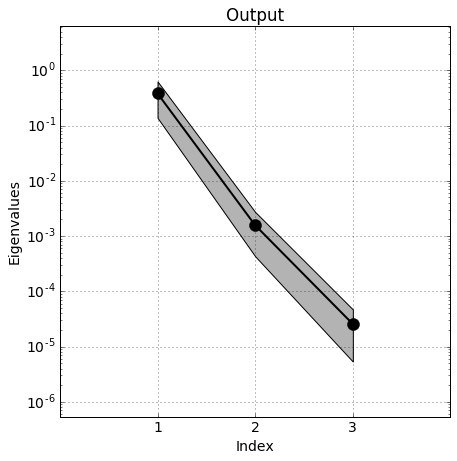

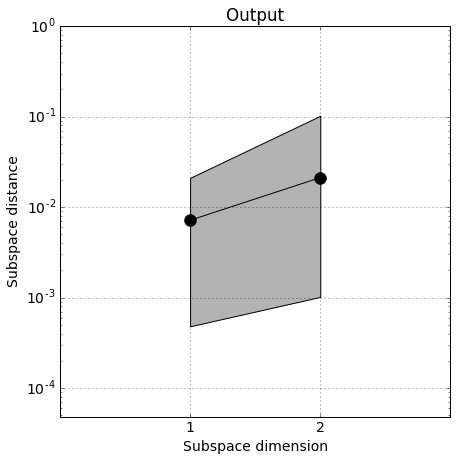

In [5]:
# Instantiate the Subspaces object.
ss = asub.subspaces.Subspaces()

# Use the gradient samples to compute the eigenvectors that define the active subspace. 
ss.compute(df=dfX0,nboot=100)

# Plot the estimated eigenvalues and errors in the estimated active subspace for varying dimension.
asub.utils.plotters.eigenvalues(ss.eigenvalues, e_br=ss.e_br)
asub.utils.plotters.subspace_errors(ss.sub_br)

Those plots can help the user determine the appropriate dimension for the active subspace. Calling `Subspaces`'s function `partition` explicitly sets the active subspace's dimension. The class `BoundedActiveVariableDomain` takes a `Subspaces` object in its constructor. It then determines the vertices of the _n_-dimensional polytope (i.e., the _zonotope_) that contains the range of the active variables. 

The class `BoundedActiveVariableMap` takes an `ActiveVariableDomain` in its constructor. It offers functions `forward` and `inverse` for going between the original variables and the active variables. `forward` returns a value for the active variables and inactive variables as tuple given a value for the original variables. `inverse` returns several values of the original variables that map to the given value of the active variables. 

In [6]:
# Define the active subspace to be one-dimensional.
ss.partition(1)

# Instantiate the domain of functions of the active variables.
avdom = asub.domains.BoundedActiveVariableDomain(ss)

# Instantiate a map between the active variables and the original variables.
avmap = asub.domains.BoundedActiveVariableMap(avdom)

The plotting utility `sufficient_summary` is an incredibly useful tool for verifying the quality of the model when the dimension of the active subspace is 1 or 2. It plots function values at particular inputs against the corresponding values of the active variables. If the plot show a strong trend, then the active subspace-enabled model may be a good model. 

The next sequence samples the inputs and computes the function values for each input. Then it uses the `BoundedActiveVariableMap` function `forward` to compute the values for the active variables. The plot then shows the relationship between the active variables and the function output. 

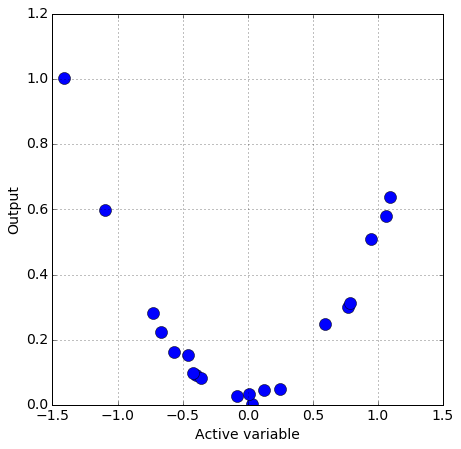

In [7]:
# Randomly sample the inputs and compute the associated outputs.
X1 = np.random.uniform(-1.0, 1.0, size=(20, m))
fX1 = asub.utils.simrunners.SimulationRunner(quad_fun).run(X1)

# Compute the value of the active variables for each sampled input.
Y1 = avmap.forward(X1)[0]

# Plot the outputs versus the value of the active variables. 
asub.utils.plotters.sufficient_summary(Y1, fX1)

The library contains tools for building multivariate, least-squares-fit polynomial approximation models. We can build a polynomial response surface on the active varibles and plot it next to the training data for comparison.

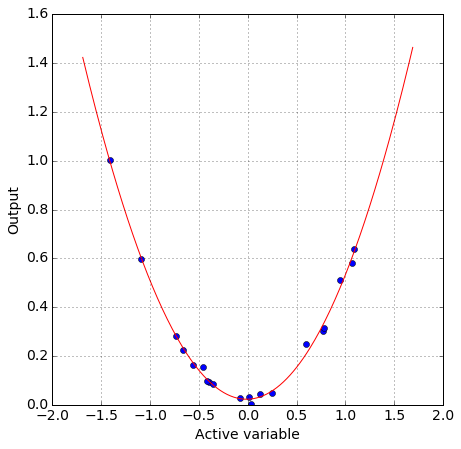

In [8]:
# Instantiate a PolynomialApproximation object of degree 2.
pr = asub.utils.response_surfaces.PolynomialApproximation(N=2)

# Fit the response surface on the active variables. 
pr.train(Y1, fX1)

# Get the upper and lower bounds of the 1d active variable
a, b = avdom.vertY[0,0], avdom.vertY[1,0]

# Evaluate the response surface over a grid of 200 points.
Y2 = np.linspace(a, b, num=200).reshape((200,1))
fY2 = pr.predict(Y2)[0]

# Plot the response surface at its training data. 
plt.figure(figsize=(7,7))
plt.plot(Y1, fX1, 'bo', Y2, fY2, 'r-')
plt.grid(True)
plt.xlabel('Active variable')
plt.ylabel('Output')
plt.show()

###Integrating
We can exploit the active subspace to efficiently integrate a function of several variables. The function `integrate` takes the interface, the `ActiveVariableMap`, the number of quadrature nodes in the active variable, and an optional argument `NMC` that specifies the number of Monte Carlo samples along the inactive variables. The computed bounds are from the Monte Carlo variance estimates. They do not include any error from the quadrature rule on the active variables. 

In [9]:
avavg = asub.integrals.integrate(quad_fun, avmap, 50, NMC=10)
print 'The estimated average is {:4.2f} with bounds [{:4.3f}, {:4.3f}].'.format(
    avavg[0], avavg[1], avavg[2])

The estimated average is 0.18 with bounds [0.182, 0.187].


###Response surfaces
The library contains a class `ActiveSubspaceResponseSurface`, whose constructor takes an `ActiveVariableMap`. We can train (or fit) the response surface by giving it the interface to the original function and the number of points used in the fit. For bounded inputs, the design is a maximin design on the zonotope.

The response surface's `predict` function takes a set of inputs and returns the response surface's prediction and gradient.

In [10]:
# Instantiate the ActiveSubspaceResponseSurface.
asrs = asub.response_surfaces.ActiveSubspaceResponseSurface(avmap)

# Fit the response surface with 21 points in the design.
asrs.train_with_interface(quad_fun, 21)

# Randomly sample the inputs.
x = np.random.uniform(-1.0, 1.0, size=(1,m))

# Compute the corresponding value of the active variable.
y = avmap.forward(x)[0][0,0]

# Evaluate the prediction, the gradient, and the variance. 
fx, dfx = asrs.predict(x, compgrad=True)
print 'At the point x = ({:4.2f}, {:4.2f}, {:4.2f}) and y = {:4.2f}...'.format(
    x[0,0], x[0,1], x[0,2], y)
print '\tthe estimate is {:4.2f},'.format(fx[0,0])
print '\tand the estimated gradient is ({:4.2f}, {:4.2f}, {:4.2f}).'.format(
    dfx[0,0], dfx[0,1], dfx[0,2])

At the point x = (0.94, 0.18, -0.72) and y = 0.65...
	the estimate is 0.23,
	and the estimated gradient is (0.28, -0.47, -0.32).


###Minimizing
The library contains utilities that use the response surface to estimate the function's minimum. The `minimize` function uses sequential least-squares quadratic program (SLSQP) solver from the `scipy.optimize` package to estimate the minimizer of the response surface over the space of active variables. Then it uses a global quadratic function on the inactive variables to estimate the function's minimum over the inactive variables with the active variables fixed at the previously computed minimizer. 

In [11]:
avmin = asub.optimizers.minimize(asrs, X1, fX1)
print 'The estimated minimum is {:4.2f} at x=({:4.2f}, {:4.2f}, {:4.2f}).'.format(
    avmin[1], avmin[0][0,0], avmin[0][0,1], avmin[0][0,2])

The estimated minimum is 0.02 at x=(-0.00, 0.00, 0.00).


###Increase the dimension of the active subspace and repeat
Next, we manually set the dimension of the active subspace to 2 and repeat the computations. Note that the `ActiveVariableMap` has the `ActiveVariableDomain`, which has the `Subspaces` object. Thus, changing the active subspace dimension with the `Subspaces.partition` function automatically changes the relationship between the active variables and the original variables. For example, the function `ActiveVariableMap.forward` now returns a vector of dimension 2 for every point in the input space you give it.

We can make a sufficient summary plot in 1 and 2 dimensions. The function `sufficient_summary` will make both the 1d and the 2d sufficient summary plot (where the latter is a scatter plot with color corresponding to the output) when the input vectors are 2d.

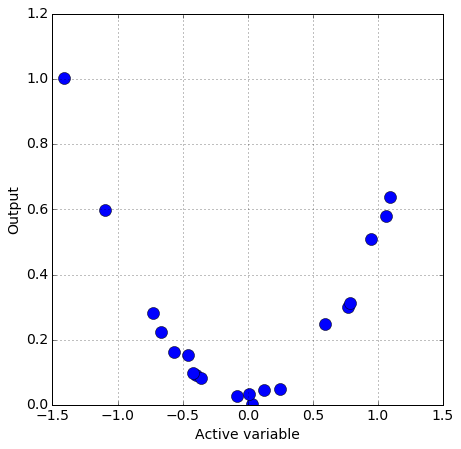

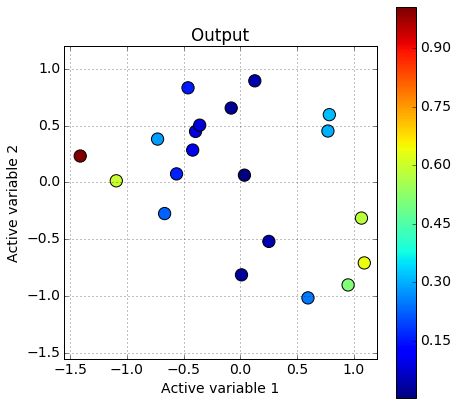

In [12]:
# Manually set the dimension of the active subspace to 2.
ss.partition(2)

# Recompute the active variable range.
avdom.compute_boundary()

# Compute the value of the active variables for samples of the original variables.
Y3 = avmap.forward(X1)[0]

# Show the 1d and 2d sufficient summary plots. 
asub.utils.plotters.sufficient_summary(Y3, fX1)

We can construct and plot the polynomial response surface on the two active variables. In principle, we can evaluate the quadratic polynomial of the active variables at points outside the range of the active variable. But this is bad practice, since those points fall outside the range of the active variables. Therefore, we use the constraints from the zonotope to throw away points from an initial grid. The remaining points are guaranteed to have corresponding points in the original variables. 

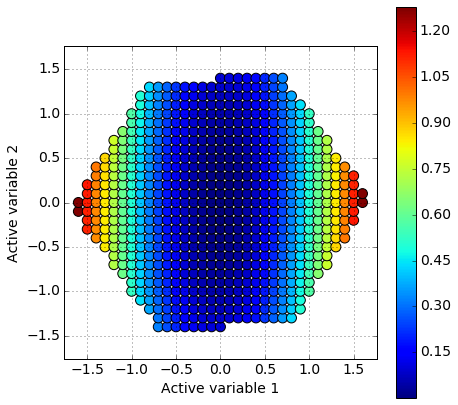

In [13]:
# Instantiate a new PolynomialApproximation object.
pr2 = asub.utils.response_surfaces.PolynomialApproximation(N=2)

# Fit the response surface with the same outputs and the 2d active variable samples.
pr2.train(Y3, fX1)

# Get all the points on a grid.
yy1, yy2 = np.meshgrid(np.arange(-3.0, 3.0, 0.1), np.arange(-3.0, 3.0, 0.1))
Y4 = np.hstack((yy1.reshape((yy1.size,1)), yy2.reshape((yy2.size,1))))

# Check to see if each point falls inside the zonotope.
ypoints = []
for y in Y4:
    if np.all(avdom.constraints['fun'](y.reshape((2,1))) >= 0):
        ypoints.append(y)
Y5 = np.array(ypoints)

# Evaluate the response surface at each point in the zonotope.
fY5 = pr2.predict(Y5)[0]

# Scatter plot of the response surface. 
y1, y2 = Y5[:,0], Y5[:,1]
plt.figure(figsize=(7,7))
plt.scatter(y1, y2, c=fY5, s=100.0, vmin=np.min(fY5), vmax=np.max(fY5))
plt.xlabel('Active variable 1')
plt.ylabel('Active variable 2')
ymin = 1.1*np.amin([np.amin(y1), np.amin(y2)])
ymax = 1.1*np.amax([np.amax(y1), np.amax(y2)])
plt.axis([ymin, ymax, ymin, ymax])
plt.axes().set_aspect('equal')
plt.grid(True)
plt.colorbar()

Construct and train a new `ActiveSubspaceResponseSurface` on the two active variables. By default, this constructor uses a radial basis approximation with a quadratic mean. Then repeat the response surface predictions, the estimated average, and the estimated minimum.

In [14]:
# Instantiate a new ActiveSubspaceResponseSurface with the 2d active variables.
asrs2 = asub.response_surfaces.ActiveSubspaceResponseSurface(avmap)

# Train the response surface on a maximin design on the zonotope.
asrs2.train_with_interface(quad_fun, 26)#30 normally, >26 -> linalg error not +def

# Evaluate the response surface prediction.
x = np.random.uniform(-1.0, 1.0, size=(1,m))
y = avmap.forward(x)[0][0,0]
fx, dfx = asrs2.predict(x, compgrad=True)
print 'At the point x = ({:4.2f}, {:4.2f}, {:4.2f}) and y = {:4.2f}...'.format(
    x[0,0], x[0,1], x[0,2], y)
print '\tthe estimate is {:4.2f},'.format(fx[0,0])
print '\tand the estimated gradient is ({:4.2f}, {:4.2f}, {:4.2f}).\n'.format(
    dfx[0,0], dfx[0,1], dfx[0,2])

# Estimate the function's average.
avavg = asub.integrals.integrate(quad_fun, avmap, 50, NMC=10)
print 'The estimated average is {:4.2f} with bounds [{:4.3f}, {:4.3f}].'.format(
    avavg[0], avavg[1], avavg[2])

# Estimate the function's minimum.
avmin = asub.optimizers.minimize(asrs2, X1, fX1)
print 'The estimated minimum is {:4.2f} at x=({:4.2f}, {:4.2f}, {:4.2f}).'.format(
    avmin[1], avmin[0][0,0], avmin[0][0,1], avmin[0][0,2])

At the point x = (-0.56, -0.52, 0.88) and y = -0.31...
	the estimate is 0.05,
	and the estimated gradient is (-0.12, 0.23, 0.17).

The estimated average is 0.20 with bounds [0.196, 0.196].
The estimated minimum is 0.00 at x=(0.02, -0.01, -0.00).
